In [10]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import networkx as nx
import random
import torch

from e3nn import o3
from torch_geometric.data import Data
from torch_geometric.nn.pool import radius_graph
from torch_geometric.utils import to_networkx

from models.mace.layers.tfn_layer import TensorProductConvLayer
from models import MACEModel
from models.mace.modules.blocks import *

In [11]:
def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Understanding MACE: step-by-step guide.

This notebook is aimed at understanding of the internal workings of MACE model introduced in the paper: [MACE: Higher Order Equivariant Message Passing Neural Networks for Fast and Accurate Force Fields](https://arxiv.org/abs/2206.07697). 

### Data creation

Let's create a random graph on which we can apply MACE and the modules


In [12]:
def create_random_graph(num_nodes=20, max_radius=1.5):
    seed()
    pos = torch.randn(num_nodes, 3)
    atoms = torch.LongTensor([0] * num_nodes)

    edge_src, edge_dst = radius_graph(pos, max_radius)
    edge_vec = pos[edge_src] - pos[edge_dst]
    edge_length = edge_vec.norm(dim=1)

    data = Data(
        atoms=atoms,
        pos=pos,
        edge_index=torch.stack([edge_src, edge_dst]),
        edge_vec=edge_vec,
        edge_length=edge_length,
    )

    return data

Let's visualize the graph we've made

In [13]:
# Convert 3D positions to 2D for visualization
data = create_random_graph()
pos_2d = {i: (data.pos[i, 0].item(), data.pos[i, 1].item()) for i in range(data.num_nodes)}

nx.draw(to_networkx(data), pos=pos_2d, with_labels=False)
plt.show()

NameError: name 'np' is not defined

### Model definition


In [ ]:
mace = MACEModel(
    r_max=5,
    num_bessel=10,
    num_polynomial_cutoff=6,
    max_ell=2,
    correlation=3,
    num_layers=5,
    emb_dim=64,
    hidden_irreps=None,
    mlp_dim=256,
    in_dim=1,
    out_dim=1,
    aggr="sum",
    pool="sum",
    batch_norm=True,
    residual=True,
    equivariant_pred=True,
)


###  MACE parameters explained

- r_max: Maximum distance for Bessel basis functions (default: 10.0)
- num_bessel: Number of Bessel basis functions (default: 8)
- num_polynomial_cutoff: Number of polynomial cutoff basis functions (default: 5)
- max_ell: Maximum degree of spherical harmonics basis functions (default: 2)
- correlation: Local correlation order = body order - 1 (default: 3)
- num_layers: Number of layers in the model (default: 5)
- emb_dim: Scalar feature embedding dimension (default: 64)
- hidden_irreps: Hidden irreps (default: None)
- mlp_dim: Dimension of MLP for computing tensor product weights (default: 256)
- in_dim: Input dimension of the model (default: 1)
- out_dim: Output dimension of the model (default: 1)
- aggr: Aggregation method to be used (default: "sum")
- pool: Global pooling method to be used (default: "sum")
- batch_norm: Whether to use batch normalization (default: True)
- residual: Whether to use residual connections (default: True)
- equivariant_pred: Whether it is an equivariant prediction task (default: False)

Note:
- If `hidden_irreps` is None, the irreps for the intermediate features are computed using `emb_dim` and `max_ell`.
- The `equivariant_pred` parameter determines whether it is an equivariant prediction task. 
If set to True, equivariant prediction will be performed.

In [ ]:
# Test the forward pass
mace(data)

tensor([[2.0032]], grad_fn=<AddmmBackward0>)

## MACE modules

First of all, we will dive into the `__init__()`step of the model and go through each of its components in detail. This will help us understand the subsequent `forward`pass.

### Initialization.

Let's start with the initialization and check what's happening there. The first step creates `radial_embeddings` for the edge features, which include the fixed (possibly learnable) Bessel functions and Polynomial cutoff functions. We will check the Bessel functions first.

#### Radial Bessel functions



In [ ]:
# Firstly, one computes edge embedding

r_max = 10
num_bessel = 100
num_polynomial_cutoff = 6

# Create radial embeddings that depend purely on the distance between atoms
radial_embedding = RadialEmbeddingBlock(
    r_max=r_max,
    num_bessel=num_bessel,
    num_polynomial_cutoff=num_polynomial_cutoff,
)

The Bessel basis functions are computed according to formula $7$ from the [Directional Message Passing for Molecular Graphs](https://arxiv.org/abs/2003.03123) paper:

$$
\tilde {e}_{RBF, n} (d) = \sqrt\frac{2}{c} \frac{sin(\frac{n\pi}{c} d)}{d},
$$

where $c$ is the cutoff radius (r_max for us), $n$ is the number of Bessel functions and $d$ is the distance.

Bessel functions: BesselBasis(r_max=10.0, num_basis=100, trainable=False)


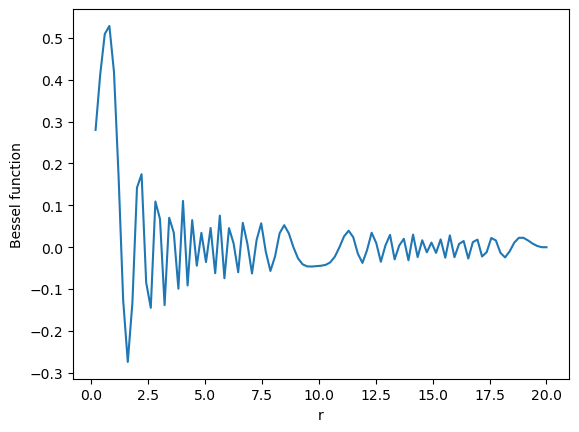

In [ ]:
# Inspect the bessel functions of the radial embedding
print(f"Bessel functions: {radial_embedding.bessel_fn}")

# Plot Bessel functions
r = torch.linspace(0, 20, 100)
plt.plot(r, radial_embedding.bessel_fn(r))
plt.xlabel("r")
plt.ylabel("Bessel function")
plt.show()

So we computed the Bessel radial basis functions at 100 points. The number of points should be equal to the number of the Bessel functions. This represenation allows us to encode distance, using non-linear functions. This basis is purely real-valued and orthogonal in the domain of interest. This is an effective way of regularizing the model that ensures that predictions are stable to small perturbations. More details are in the paper.

**Notice how the embedding go to zero near the cutoff radius!**

### Polynomial cutoff functions

Those polynomial functions $u(d)$ play a role of an envelope function that transforms the Bessel functions in such a way that makes them double-differentiable with the 1st and 2nd derivatives being 0 at the cutoff distance $c$ (r_max). They implement formula $8$ from the [paper](https://arxiv.org/abs/2003.03123). 

$$
u(d) = 1 - \frac{(p+1)(p+2)}{2} d^p + p(p+2)d^{p+1} - \frac{p(p+1)}{2} d^{p+2},
$$

where $p=6$ was chosen as a default experimentally.

**NB** the actual code implementation uses a slightly modified formula, which simplifies the derivative computation and explicitly takes into account the cutoff (r_max).

The modified Bessel functions will look like this:

$$
e_{RBF,n} (d) = u(d) \tilde {e}_{RBF,n}(d) 
$$


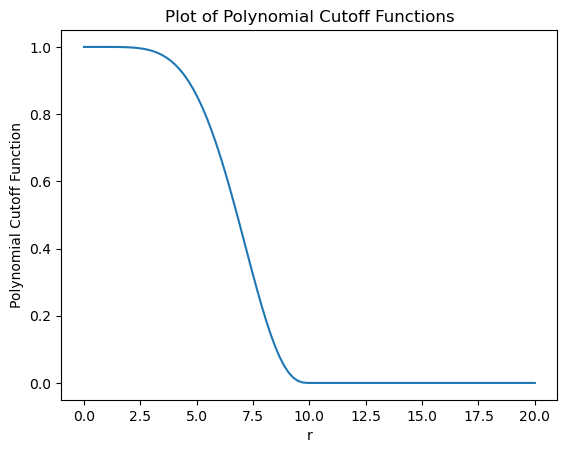

In [ ]:
# Plot polynomial cutoff functions
plt.plot(r, radial_embedding.cutoff_fn(r))
plt.xlabel("r")
plt.ylabel("Polynomial Cutoff Function")
plt.title("Plot of Polynomial Cutoff Functions")
plt.show()

Let's plot the combined radial embeddings produced by the product of the Bessel and Polynomial cutoff functions.

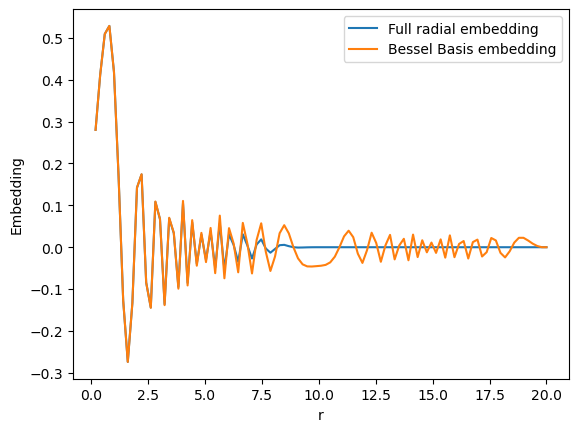

In [ ]:
# Plot the radial embedding
plt.plot(r, radial_embedding(r), label="Full radial embedding")
plt.plot(r, radial_embedding.bessel_fn(r), label="Bessel Basis embedding")
plt.xlabel("r")
plt.ylabel("Embedding")
plt.legend()
plt.show()

**Polynomial cutoff functions help us to have essentially zero embeddings at the distance bigger than the cutoff radius. Notice, how the full radial embedding zeros out after the cutoff and the Bessel functions based embeddings continue to be non-zero.**

### Spherical harmonics

Edge features are not only represented through its length, which is embedded via the `radial_embeddings`functions described above, but also through 3D vectors that connect 2 atoms. Those vectors are encoded with the help of [spherical harmonics](https://en.wikipedia.org/wiki/Spherical_harmonics), which can be seen as orthonormal basis functions defined on a sphere. They are complex-valued polynomials and solutions to a partial differential equation in 3D, e.g. the heat propagation equation.

MACE implements them with the help of the `e3nn` package that has a module called `o3`. It's a module that contains operations that are used with the O(3)-group.

Let's create the SH (spherical harmonics) functions for embedding 3D vectors.

In [ ]:
# Max order of the spherical harmonics
max_ell = 2

# First, we create the irreducable representations of the spherical harmonics up to an order of `max_ell`
sh_irreps = o3.Irreps.spherical_harmonics(max_ell)

# Next, we create the spherical harmonics functions that can be applied to the edge coordinates
spherical_harmonics = o3.SphericalHarmonics(sh_irreps, normalize=True, normalization="component")


In [ ]:
print(f"Dimension of spherical harmonics irreps: {sh_irreps.dim}")
print(f"Number of : {sh_irreps.num_irreps}")

Dimension of spherical harmonics irreps: 9
Number of : 3


The irreps (irreducable representations) of spherical harmonics are given by different tensors: 

- for degree l=0 it is just a number and has dimension 1
- for degree l=1 it's a vector that has 3 values, corresponding to its different orders = [-1, 0, 1] that go from -l to l with a step of 1.
- for degree l=2 it's a vector that has 5 values, corresponding to its different orders = [-2, -1, 0, 1, 2]

So that's why we have dimension = 9 and number of irreps = 3 (1 for each degree).


In `e3nn` irreps are written as follows:

In [ ]:
print(f"Spherical harmonics irreps: {sh_irreps}")

Spherical harmonics irreps: 1x0e+1x1o+1x2e


This tells us how many irreps of each degree we have. And `e`and `o` letters give us their parity: odd or even, which is important for O(3) group. More on that is given in the manual of `e3nn` package [here](https://docs.e3nn.org/en/stable/guide/irreps.html).

The object `spherical harmonics` has all the info that is needed to compute the actual values. Let's compute spherical harmonics for a few edges of our graph.

In [ ]:
print(f"Spherical harmonics of the first 5 edge vectors: \n\n {spherical_harmonics(data.edge_vec[:5])}")

Spherical harmonics of the first 5 edge vectors: 

 tensor([[ 1.0000,  1.0847,  1.2663, -0.4690, -0.6568,  1.7732,  0.6747, -0.7667,
         -0.6175],
        [ 1.0000,  1.0146, -1.2064,  0.7177,  0.9402, -1.5802,  0.5091, -1.1178,
         -0.3320],
        [ 1.0000,  1.4092,  0.8032,  0.6075,  1.1053,  1.4612, -0.3968,  0.6299,
         -1.0436],
        [ 1.0000,  1.7220, -0.0950, -0.1604, -0.3565, -0.2112, -1.1079,  0.0197,
         -1.8975],
        [ 1.0000,  0.8810,  0.7715,  1.2762,  1.4514,  0.8775, -0.4525,  1.2711,
          0.5503]])


As we see we get 9 numbers for each edge. Those numbers are the values of the spherical harmonics of different degrees and orders. It's a way to represent a 3D coordinate, using that orthonormal basis that under further assumptios can be used to build O(3)-equivariant operations.

### Node embeddings

Node embeddings are given via a simple look-up table that takes an `index`of an atom/node and generates an embedding for it. The default value is $1$, meaning that we have only $1$ atom type, which we also have in our toy data set.

In [ ]:
# Initialize an embedding layer
emb_in = torch.nn.Embedding(num_embeddings=1, embedding_dim=64)

# Run it on the atom types
atom_emb = emb_in(data.atoms)
print(f"First atom embedding: \n\n {atom_emb[:1]} \n")
print(f"Shape of atom embeddings: {atom_emb.shape}")

First atom embedding: 

 tensor([[-1.1274, -0.2718, -0.8836,  0.1095, -0.6212, -2.4722, -0.3185,  1.1852,
         -1.2132, -0.0300, -1.9756,  0.3856, -0.7330,  1.5573, -1.8170, -0.1566,
          0.8866, -0.5308, -0.1385, -1.1482, -0.5655,  0.3192,  1.8989, -0.4577,
         -1.1856, -0.2765, -0.2578, -0.8542, -0.0831,  2.9297, -0.0637, -0.8791,
         -0.9978, -1.7292,  0.9287,  0.4997, -0.0221,  0.0808, -0.0828,  2.8363,
         -0.1697, -0.9571,  0.8933,  1.3312,  0.2678,  0.7790, -0.3088, -0.2121,
          0.6075, -1.1625,  1.1183, -0.1935,  0.3115, -2.5182,  0.5080,  0.5837,
          2.0736,  0.4273,  1.2922, -0.8266,  0.5197, -0.1899,  0.0125,  0.6635]],
       grad_fn=<SliceBackward0>) 

Shape of atom embeddings: torch.Size([20, 64])


### Computation of the hidden irreps

Hidden irreps are given by None as default and they are computed, using the embedding dimension and the irreps of the spherical harmonics. 

In [ ]:
# Compute hidden irreps
# Note: This defaults to O(3) equivariant layers.

emb_dim = 64
hidden_irreps = (sh_irreps * emb_dim).sort()[0].simplify()
print(f"Hidden irreps: {hidden_irreps}")
print(f"Number of hidden irreps: {hidden_irreps.dim}")


Hidden irreps: 64x0e+64x1o+64x2e
Number of hidden irreps: 576


This gives us $64$ irreps of each degree of the spherical harmonics specified above, i.e.:
 - $64$ values for the irreps of degree $0$
 - $64 \cdot 3$ values for degree $1$ 
 - $64 \cdot 5$ for degree 2.

### Stacking conv layers

The next steps in the init create tensor convolutional layers. Tensor convolution is described in the paper on [Tensor field networks: Rotation- and translation-equivariant neural networks for 3D point clouds](https://arxiv.org/abs/1802.08219).

The first layer converts the scalar input to the tensor one and is called `TensorProductConvLayer`. Let's have a closer look at it. This layer **is** the layer from the tensor filed networks (TFN) paper.

In [ ]:
mlp_dim = 256
aggr = "sum"
batch_norm = True

# Create a tensor product layer
tp_layer = TensorProductConvLayer(
    in_irreps=o3.Irreps(f"{emb_dim}x0e"),
    out_irreps=hidden_irreps,
    sh_irreps=sh_irreps,
    edge_feats_dim=radial_embedding.out_dim,
    mlp_dim=mlp_dim,
    aggr=aggr,
    batch_norm=batch_norm,
    gate=False,
)

Let's visualize the tensor product inside the layer and print some info about the irreps.

Input irreps: 64x0e
Output irreps: 64x0e+64x1o+64x2e
Number of output irreps: 576


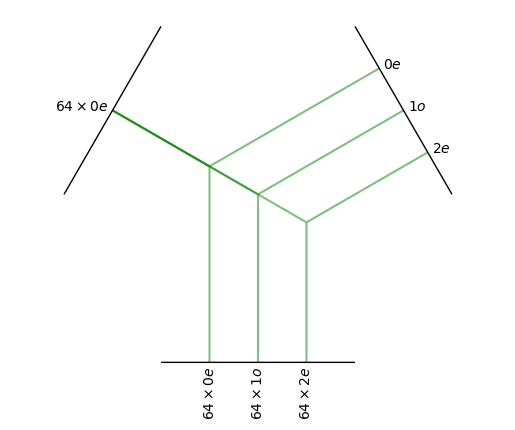

In [ ]:
print(f"Input irreps: {tp_layer.in_irreps}")
print(f"Output irreps: {tp_layer.out_irreps}")
print(f"Number of output irreps: {tp_layer.out_irreps.dim}")
tp_layer.tp.visualize();

In [ ]:
tp_layer.tp.instructions

[Instruction(i_in1=0, i_in2=0, i_out=0, connection_mode='uvw', has_weight=True, path_weight=0.125, path_shape=(64, 1, 64)),
 Instruction(i_in1=0, i_in2=1, i_out=1, connection_mode='uvw', has_weight=True, path_weight=0.21650635094610965, path_shape=(64, 1, 64)),
 Instruction(i_in1=0, i_in2=2, i_out=2, connection_mode='uvw', has_weight=True, path_weight=0.2795084971874737, path_shape=(64, 1, 64))]

In [ ]:
assert(tp_layer.tp.weight_numel == 3*(64 * 64))
print("Assertion passed: the number of weights matches the expected value.")


Assertion passed: the number of weights matches the expected value.


So the output irreps of each degree have the multiplicity of $64$. Each of those irreps for each degree is a learned linear combination
of $64$ irreps of oder zero combined with all the other degrees and multiplicities of the spherical harmonics. This is
what the picture shows us. For example, there are $64$ scalars of the input irreps and we can combine them in $64$ different
ways with the single scalar irrep of the spherical harmonics. Then we can use different weights to create **ANY** number 
of such linear combinations, though in our case this number is also $64$. That's why we have $64$ linear combinations of irreps
with $64$ different weights in each combination. This can also be seen in the instructions printed above. 

Those weights are learned with a separate MLP inside the `tfn_layer`, which is represented by `h` in the next formula below.


This layer implements the following formula:

$$
f_i^{'} = \sum_{j \in N_i} f_j \otimes  \left[ h(\text{Emb}(||x_{ij}||)) Y (\frac{x_{ij}}{||x_{ij}||}) \right]

$$
  
 
where 

* $f_i, f_i^{'}$ are the nodes input and output features
* $N_i$ is the set of neighbors of the node 
* $x_{ij}$ is the relative vector
* $h$ is a multi layer perceptron
* $Y$ are the spherical harmonics
* $x \otimes (w) y$ is a tensor product of $x$ with $y$ parametrized by some weights $w$


Then optional gating and batch norm is applied. 



#### Steps realised in the layer's forward pass:

1. Steps in the squared brackets:

$$
 \left[ h(\text{Emb}(||x_{ij}||)) Y (\frac{x_{ij}}{||x_{ij}||}) \right]
$$

* The layer uses spherical harmonics computed for edges in the graph (we did it above in this notebook).
* Then it computes some weights for those spherical harmonics, using MLP $h$ and `radial_embeddings` $\text{Emb}(||x_{ij}||)$
of the edges that we also discussed above. 

2. A tensor product is computed between the node features and the output of the precious step. The info on the tensor product 
is given in the `e3nn` tutorial [here](https://docs.e3nn.org/en/stable/api/o3/o3_tp.html).

3. Then those features are aggregated accross all the nodes to construct the messages

4. Optional gating and batch normalization applied. We won't cover that here, since by default it's disabled. More info is
given in the `e3nn` tutorial [here](https://docs.e3nn.org/en/stable/api/nn/nn_gate.html)

### Reshape & Equivariant product basis block

Each tensor convolutional layer is followed by a reshape operation applied to the irreps and the consequent application of
the Equivariant product basis block. 

#### Reshape operation

The class `reshape_irreps` is provided to perform the reshaping. It's a `torch`module, which is initialized with give irreps
of the class `o3.Irreps`. Let's check out how it works.

In [ ]:
# EXAMPLE 1

# The multiplicities must match here
irreps_test = o3.Irreps([(10, (0, -1)), (10, (1, 1)), (10, (2, -1))])
print(f"Irreps to initialize the class with: {irreps_test}")
print(f"Dimension of the irreps: {irreps_test.dim}")

reshape = reshape_irreps(irreps_test)

t_1 = torch.arange(90).reshape(1, -1)
t_2 = torch.arange(130).reshape(1, -1)
print(f"Shape of t_1: {t_1.shape}")
print(f"Shape of t_2: {t_2.shape}")
reshaped_t_1 = reshape(t_1)
reshaped_t_2 = reshape(t_2)
print(f"Shape of reshaped t_1: {reshaped_t_1.shape}")
print(f"Shape of reshaped t_2: {reshaped_t_2.shape}")

Irreps to initialize the class with: 10x0o+10x1e+10x2o
Dimension of the irreps: 90
Shape of t_1: torch.Size([1, 90])
Shape of t_2: torch.Size([1, 130])
Shape of reshaped t_1: torch.Size([1, 10, 9])
Shape of reshaped t_2: torch.Size([1, 10, 9])


In [ ]:
# EXAMPLE 2
irreps_test = o3.Irreps([(10, (0, -1)), (10, (1, 1)), (10, (2, -1)), (10, (3, 1))])
print(f"Irreps to initialize the class with: {irreps_test}")
print(f"Dimension of the irreps: {irreps_test.dim}")

reshape = reshape_irreps(irreps_test)

t_1 = torch.arange(160).reshape(1, -1)
t_2 = torch.arange(230).reshape(1, -1)
print(f"Shape of t_1: {t_1.shape}")
print(f"Shape of t_2: {t_2.shape}")
reshaped_t_1 = reshape(t_1)
reshaped_t_2 = reshape(t_2)
print(f"Shape of reshaped t_1: {reshaped_t_1.shape}")
print(f"Shape of reshaped t_2: {reshaped_t_2.shape}")

Irreps to initialize the class with: 10x0o+10x1e+10x2o+10x3e
Dimension of the irreps: 160
Shape of t_1: torch.Size([1, 160])
Shape of t_2: torch.Size([1, 230])
Shape of reshaped t_1: torch.Size([1, 10, 16])
Shape of reshaped t_2: torch.Size([1, 10, 16])


So `reshape_irreps` `forward` method reshapes a given tensor to the size of [`batch`, `mul`, `d`], where:

- `batch` is the batch size of the tensor. Number of atoms in our case
- `mul` is the multiplicity of each degree of irreps that are given in the `__init__` method. **The multiplicities must 
be the same!**
- `d` is the sum of the dimensions of each degree of the irreps given at the intialization. It is equal to $(l_{max} + 1)²$,
where $l_{max}$ is the maximum irreps degree.

The input tensor must have the dimensionality, which is bigger or equal the dimensionality of the irreps given at the initialization.

The output tensor's dimensionality is fixed at [`batch`, `mul`, `d`] and if the dimensionality of the input tensor is bigger
than `mul`* `dim` then the extra elements are simply ignored and thrown away.


#### Equivariant product basis block

The next element is the equivaraint product basis block. Let's dig into it.

This block's forward method does the following:

1. Applies the `symmetric contraction` 
2. Uses the output of the previous step and an `o3.Linear` equivariant layer to update the node features.
3. Applies a possible batch norm.
4. Applies a possible skip connection.  

##### Symmetric contraction

Symmetric contraction is the *key* operation of MACE that allows to compute higher order tensor features efficiently, 
forming their tensor products and then symmetrizing them. The algorithm is described in the 
[MACE](https://arxiv.org/abs/2206.07697) paper and corresponds to equiations $(10)$ and $(11)$. For more details, please
refer to the paper.

The core of this block is the class `Contraction`. 

In [36]:
# Exploration of Contraction class
node_feats_irreps = o3.Irreps([(2, (0, 1)), (3, (1, -1)), (2, (3, 1))]) # input irreps for the contraction layer
target_irreps = o3.Irreps([(3, (0, 1)), (1, (1, -1)), (4, (3, 1))]) # output irreps for the contraction layer
correlation = 3 # the correlation order
element_dependent = False # whether the weight matrices for message construction are computed for each atom type
num_elements = 1 # input dimension of MACE (the number of different atoms, which is 1 in our case)
use_sc = True # use the skip connection

epbb = EquivariantProductBasisBlock(
    node_feats_irreps=node_feats_irreps,
    target_irreps=target_irreps,
    correlation=correlation,
    element_dependent=element_dependent,
    num_elements=num_elements,
    use_sc=use_sc,
)

contractions = epbb.symmetric_contractions.contractions

epbb = EquivariantProductBasisBlock(
    node_feats_irreps=node_feats_irreps,
    target_irreps=target_irreps,
    correlation=correlation,
    element_dependent=True, # allow it to be element dependent
    num_elements=3, # set the number of elements to 3
    use_sc=use_sc,
)

contractions_el_dep = epbb.symmetric_contractions.contractions


In [37]:
for p in contractions["3x0e"].weights.values():
    print(p)

Parameter containing:
tensor([[-0.0053, -0.1965]], requires_grad=True)
Parameter containing:
tensor([[-0.3250,  0.1017],
        [ 0.3368, -0.1619],
        [ 0.8216,  0.4661]], requires_grad=True)
Parameter containing:
tensor([[ 0.1178, -0.2749],
        [ 0.0148,  0.0016],
        [-0.0394, -0.3133],
        [-0.0052,  0.1167],
        [-0.0234, -0.2797],
        [-0.0477, -0.1129],
        [ 0.0356, -0.0023],
        [ 0.1352,  0.2156]], requires_grad=True)


In [38]:
print(f"Element independent contractions: \n {contractions} \n\n")


Element independent contractions: 
 ModuleDict(
  (3x0e): Contraction(
    (weights): ParameterDict(
        (1): Parameter containing: [torch.FloatTensor of size 1x2]
        (2): Parameter containing: [torch.FloatTensor of size 3x2]
        (3): Parameter containing: [torch.FloatTensor of size 8x2]
    )
  )
  (1x1o): Contraction(
    (weights): ParameterDict(
        (1): Parameter containing: [torch.FloatTensor of size 1x2]
        (2): Parameter containing: [torch.FloatTensor of size 2x2]
        (3): Parameter containing: [torch.FloatTensor of size 15x2]
    )
  )
  (4x3e): Contraction(
    (weights): ParameterDict(
        (1): Parameter containing: [torch.FloatTensor of size 1x2]
        (2): Parameter containing: [torch.FloatTensor of size 3x2]
        (3): Parameter containing: [torch.FloatTensor of size 22x2]
    )
  )
) 




In [30]:
print(f"Element dependent contractions: \n {contractions_el_dep}")

Element dependent contractions: 
 ModuleDict(
  (3x0e): Contraction(
    (weights): ParameterDict(
        (1): Parameter containing: [torch.FloatTensor of size 3x1x2]
        (2): Parameter containing: [torch.FloatTensor of size 3x3x2]
    )
  )
  (1x1o): Contraction(
    (weights): ParameterDict(
        (1): Parameter containing: [torch.FloatTensor of size 3x1x2]
        (2): Parameter containing: [torch.FloatTensor of size 3x4x2]
    )
  )
  (4x2e): Contraction(
    (weights): ParameterDict(
        (1): Parameter containing: [torch.FloatTensor of size 3x1x2]
        (2): Parameter containing: [torch.FloatTensor of size 3x4x2]
    )
  )
)


`Contraction` class implements all neccessara operations to contract tensors:
 - It computes generalized Clebsch-Gordan coefficients and stores them in the `U_tensor` object
 - It creates respective weight matrices for each pair of input 2-body tensor features and its corresponding CG-cooefficients
 These matrices are plotted above
 - Then it computes tensor products from equation $(11)$ that creates messages that are passed along the graph edges.


#### Some observations 

- The input and output irreps for the contraction layer must have exactly the same degree and order, but the multiplicities
can vary.
- The input irreps must have the irreps of degree 0.